# Compare Sentinel-1 Public precise orbit position to TLE from Spacetrack

NOTE: this is for most recent TLE, which tend to be ~1/day

In [1]:
# Compare with perpendicular baseline from TLE
import netrc
import numpy as np
import requests
import skyfield.api as sky
import pandas as pd
from eof.download import download_eofs

In [2]:
pd.Timestamp.now()

Timestamp('2023-11-22 21:05:50.148345')

## Step 1, consider latest public TLE from Spacetrack:

In [3]:
# Let's see if there are any TLEs in this observation validity window:
!chmod 600 ~/.netrc
parse = netrc.netrc()
login, account, password = parse.authenticators("space-track.org")

In [4]:
session = requests.Session()
response = session.post('https://www.space-track.org/ajaxauth/login', data={'identity': login, 'password': password})

In [5]:
norad_id = '39634'
API = 'https://www.space-track.org/basicspacedata/query'

In [6]:
# start = '2023-10-15 22:59:42'
# end = '2023-10-17 00:59:42'
# query = f'{API}/class/gp_history/NORAD_CAT_ID/{norad_id}/EPOCH/{start}--{end}/orderby/CREATION_DATE%20DESC/format/json'

query = f'{API}/class/gp/NORAD_CAT_ID/{norad_id}/format/json'

data = session.get(query).json()
df = pd.DataFrame(data)
cols = ['EPOCH','CREATION_DATE','GP_ID']
print(len(df))
df[cols].head(3)

1


,EPOCH,CREATION_DATE,GP_ID
0,2023-11-22T14:02:15.919872,2023-11-22T19:50:02,242826032


In [7]:
df.iloc[0].TLE_LINE0

'0 SENTINEL 1A'

In [8]:
s = df.iloc[0]
with pd.option_context('display.max_colwidth', None):
    print(s.TLE_LINE0)
    print(s.TLE_LINE1)
    print(s.TLE_LINE2)

0 SENTINEL 1A
1 39634U 14016A   23326.58490648  .00000353  00000-0  84566-4 0  9991
2 39634  98.1821 331.6729 0001275  89.6364 270.4982 14.59202245513283


## Construct State Vector from TLE

In [9]:
tle = df.iloc[-1]
satellite = sky.EarthSatellite(tle.TLE_LINE1, tle.TLE_LINE2, 'Sentinel-1A')
satellite

<EarthSatellite Sentinel-1A catalog #39634 epoch 2023-11-22 14:02:16 UTC>

In [10]:
from skyfield.framelib import itrs

In [11]:
geocentric = satellite.at(satellite.epoch)
p,v = geocentric.frame_xyz_and_velocity(itrs)
print(p.m)
print(v.m_per_s)

[3.55950718e+06 6.11652886e+06 3.13970461e+00]
[1364.36354727 -804.19539975 7430.37264748]


In [12]:
#satellite.epoch.utc_datetime()
date = satellite.epoch.utc_iso()[:-1] #drop Z (UTC)

In [13]:
satellite.epoch.utc_iso() # not as precise as datetime()! microseconds do count :) 

'2023-11-22T14:02:16Z'

In [14]:
# Get orbit for S1... hmm quite slow.
paths = download_eofs([date], ['S1A'])

In [15]:
def read_orbit_file(path):
    df = pd.read_xml(path, xpath="//OSV")
    df = df.drop(columns=['TAI','UT1'])
    df['UTC'] = pd.to_datetime(df.UTC.str[4:])
    df.set_index('UTC', drop=False, inplace=True)
    
    return df

df = read_orbit_file(paths[0])
df.head()

,UTC,Absolute_Orbit,X,Y,Z,VX,VY,VZ,Quality
UTC,,,,,,,,,
2023-11-22 12:23:26.030215,2023-11-22 12:23:26.030215,51329,671303.467435,7.044994e+06,-39832.009154,1579.529923,-117.236640,7430.106538,NOMINAL
2023-11-22 12:23:36.030215,2023-11-22 12:23:36.030215,51330,687059.796022,7.043415e+06,34469.904541,1571.686573,-198.480555,7430.136421,NOMINAL
2023-11-22 12:23:46.030215,2023-11-22 12:23:46.030215,51330,702736.215901,7.041024e+06,108767.922845,1563.548338,-279.693419,7429.327457,NOMINAL
2023-11-22 12:23:56.030215,2023-11-22 12:23:56.030215,51330,718329.783012,7.037821e+06,183053.657379,1555.116184,-360.865612,7427.679681,NOMINAL
2023-11-22 12:24:06.030215,2023-11-22 12:24:06.030215,51330,733837.563186,7.033807e+06,257318.720603,1546.391124,-441.987517,7425.193225,NOMINAL


In [16]:
len(df) # 3 hours of timestamped orbit data every 10 seconds.
df.UTC.describe()

count                             1186
mean     2023-11-22 14:02:11.030214912
min         2023-11-22 12:23:26.030215
25%      2023-11-22 13:12:48.530214912
50%      2023-11-22 14:02:11.030214912
75%      2023-11-22 14:51:33.530214912
max         2023-11-22 15:40:56.030215
Name: UTC, dtype: object

In [17]:
epoch = pd.Timestamp(satellite.epoch.utc_datetime()).tz_localize(None)
epoch

Timestamp('2023-11-22 14:02:15.919861')

In [18]:
idx = df.index.get_indexer([epoch], method='nearest') 
df.iloc[idx]

,UTC,Absolute_Orbit,X,Y,Z,VX,VY,VZ,Quality
UTC,,,,,,,,,
2023-11-22 14:02:16.030215,2023-11-22 14:02:16.030215,51331,3.559637e+06,6.116507e+06,-0.000002,1364.277382,-804.055331,7430.297623,NOMINAL


In [19]:
# TLE epoch time - will Z usually be around zero / passing ascending node?
(epoch - df.iloc[idx].index[0]).total_seconds()

-0.11035399999999995

In [20]:
def estimate_position_from_orbit(df, epoch):
    # Get closest orbital timestamp to this epoch
    iloc_idx = df.index.get_indexer([epoch], method='nearest') 
    dt = (epoch - df.iloc[iloc_idx].index[0]).total_seconds()

    # 'interpolate' orbit by using velocity vectors at nearest position
    positions=['X','Y','Z']
    velocities=['VX','VY','VZ'] #
    p = df.iloc[iloc_idx].loc[:,positions].values[0] + dt*df.iloc[iloc_idx].loc[:,velocities].values[0]
    
    return p

In [21]:
p_eof = estimate_position_from_orbit(df, epoch)

In [22]:
# Wow. within ~200 m of 'true' position
# Hmm, why did this change? new EOF or new res-orb downloaded?
diff = p_eof - p.m
diff

array([ -20.9782171 ,   67.00848824, -823.1027705 ])

In [23]:
#ts = sky.load.timescale()
# Neesd UTC-awarre times
#times = ts.from_datetimes()
#geocentric = satellite.at(times)
#p,v = geocentric.frame_xyz_and_velocity(itrs)
#p.m.shape

In [24]:
# TLE estimate position will degrade over time. Generate estimated position for every poe timestamp:
# (uses SGP4 propagator)
def propagate_tle(times):
    '''input: utc-aware pandas timestamps return arrays of position and velocity (state vectors)'''
    ts = sky.load.timescale()
    # Neesd UTC-awarre times
    skytimes = ts.from_datetimes(times)
    geocentric = satellite.at(skytimes)
    p,v = geocentric.frame_xyz_and_velocity(itrs)
    return p.m, v.m_per_s

In [25]:
ind = idx[0]
P, V = propagate_tle(df.iloc[ind:ind+2].UTC.dt.tz_localize('UTC'))
P

array([[3.55965772e+06, 3.57309109e+06],
       [6.11644007e+06, 6.10803788e+06],
       [8.23112801e+02, 7.51254455e+04]])

In [26]:
# Function that operates on one row at a time
def propagate_positions(row, satellite):
    ''' operate on single row, get satellite position from timestamp'''
    ts = sky.load.timescale()
    skytimes = ts.from_datetime(row.UTC.tz_localize('UTC'))
    geocentric = satellite.at(skytimes)
    p,v = geocentric.frame_xyz_and_velocity(itrs)
    P = p.m
    V = v.m_per_s
    
    # construct dataframe of results using row index
    #df = pd.DataFrame(dict(X=P[0], Y=P[1], Z=P[2], VX=V[0], VY=V[1], VZ=V[2]),
    #                  index=[row.UTC])
    
    # Return and series and 'apply' will construct a dataframe with row.index
    df = pd.Series(dict(X=P[0], Y=P[1], Z=P[2], VX=V[0], VY=V[1], VZ=V[2]))
    
    return df

In [27]:
propagate_positions(df.iloc[ind], satellite)

X     3.559658e+06
Y     6.116440e+06
Z     8.231128e+02
VX    1.363910e+03
VY   -8.049739e+02
VZ    7.430373e+03
dtype: float64

In [28]:
dfTLE = propagate_positions(df.iloc[ind], satellite)

In [29]:
# Apply to all timestamps
dfTLE = df[:3].apply(propagate_positions, args=(satellite,), axis=1)
dfTLE

,X,Y,Z,VX,VY,VZ
UTC,,,,,,
2023-11-22 12:23:26.030215,671295.375892,7.044893e+06,-39616.622956,1579.687043,-117.562420,7430.249784
2023-11-22 12:23:36.030215,687053.315169,7.043312e+06,34686.764269,1571.844001,-198.812446,7430.277601
2023-11-22 12:23:46.030215,702731.349056,7.040917e+06,108986.235446,1563.706023,-280.031457,7429.466442


In [30]:
# Now we can diff the dataframes directly
cols = ['X','Y','Z','VX','VY','VZ']
(dfTLE - df[cols]).dropna()

,X,Y,Z,VX,VY,VZ
UTC,,,,,,
2023-11-22 12:23:26.030215,-8.091543,-100.120861,215.386198,0.157120,-0.325780,0.143246
2023-11-22 12:23:36.030215,-6.480853,-103.366072,216.859728,0.157428,-0.331891,0.141180
2023-11-22 12:23:46.030215,-4.866845,-106.672432,218.312601,0.157685,-0.338038,0.138985


In [31]:
dfTLE = df.apply(propagate_positions, args=(satellite,), axis=1)
dfTLE

,X,Y,Z,VX,VY,VZ
UTC,,,,,,
2023-11-22 12:23:26.030215,6.712954e+05,7.044893e+06,-39616.622956,1579.687043,-117.562420,7430.249784
2023-11-22 12:23:36.030215,6.870533e+05,7.043312e+06,34686.764269,1571.844001,-198.812446,7430.277601
2023-11-22 12:23:46.030215,7.027313e+05,7.040917e+06,108986.235446,1563.706023,-280.031457,7429.466442
2023-11-22 12:23:56.030215,7.183265e+05,7.037711e+06,183273.400909,1555.274070,-361.209824,7427.816339
2023-11-22 12:24:06.030215,7.338359e+05,7.033693e+06,257539.871796,1546.549151,-442.337926,7425.327421
...,...,...,...,...,...,...
2023-11-22 15:40:16.030215,5.741975e+06,4.124094e+06,-330131.540861,1198.803586,-1089.551189,7422.091953
2023-11-22 15:40:26.030215,5.753633e+06,4.112959e+06,-255893.334436,1132.766832,-1137.405724,7425.399875
2023-11-22 15:40:36.030215,5.764630e+06,4.101347e+06,-181626.238750,1066.530824,-1185.038255,7427.869630


In [32]:
diff = (dfTLE - df[cols]).dropna()
diff

,X,Y,Z,VX,VY,VZ
UTC,,,,,,
2023-11-22 12:23:26.030215,-8.091543,-100.120861,215.386198,0.157120,-0.325780,0.143246
2023-11-22 12:23:36.030215,-6.480853,-103.366072,216.859728,0.157428,-0.331891,0.141180
2023-11-22 12:23:46.030215,-4.866845,-106.672432,218.312601,0.157685,-0.338038,0.138985
2023-11-22 12:23:56.030215,-3.250054,-110.040299,219.743530,0.157886,-0.344212,0.136658
2023-11-22 12:24:06.030215,-1.631058,-113.469983,221.151193,0.158027,-0.350409,0.134196
...,...,...,...,...,...,...
2023-11-22 15:40:16.030215,129.862472,-96.566878,1205.787451,-1.115213,-0.725538,0.099600
2023-11-22 15:40:26.030215,118.746685,-103.808279,1206.764299,-1.118993,-0.722745,0.085949
2023-11-22 15:40:36.030215,107.594455,-111.021431,1207.604926,-1.122620,-0.719859,0.072242


In [33]:
diff.describe()

,X,Y,Z,VX,VY,VZ
count,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000
mean,31.987525,9.100790,-165.506580,0.005218,-0.005569,0.083846
std,435.256297,615.453804,734.208662,0.474305,0.664274,0.773329
min,-748.736415,-952.764203,-1370.699271,-1.129410,-0.928388,-1.183693
25%,-211.523176,-583.720208,-853.152435,-0.256799,-0.583587,-0.641478
50%,21.063749,-11.852311,-125.244354,-0.021791,-0.131682,0.091238
75%,192.795191,617.214651,443.647074,0.263098,0.643461,0.796629
max,972.756812,925.655718,1208.875517,1.002512,1.068298,1.389390


In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

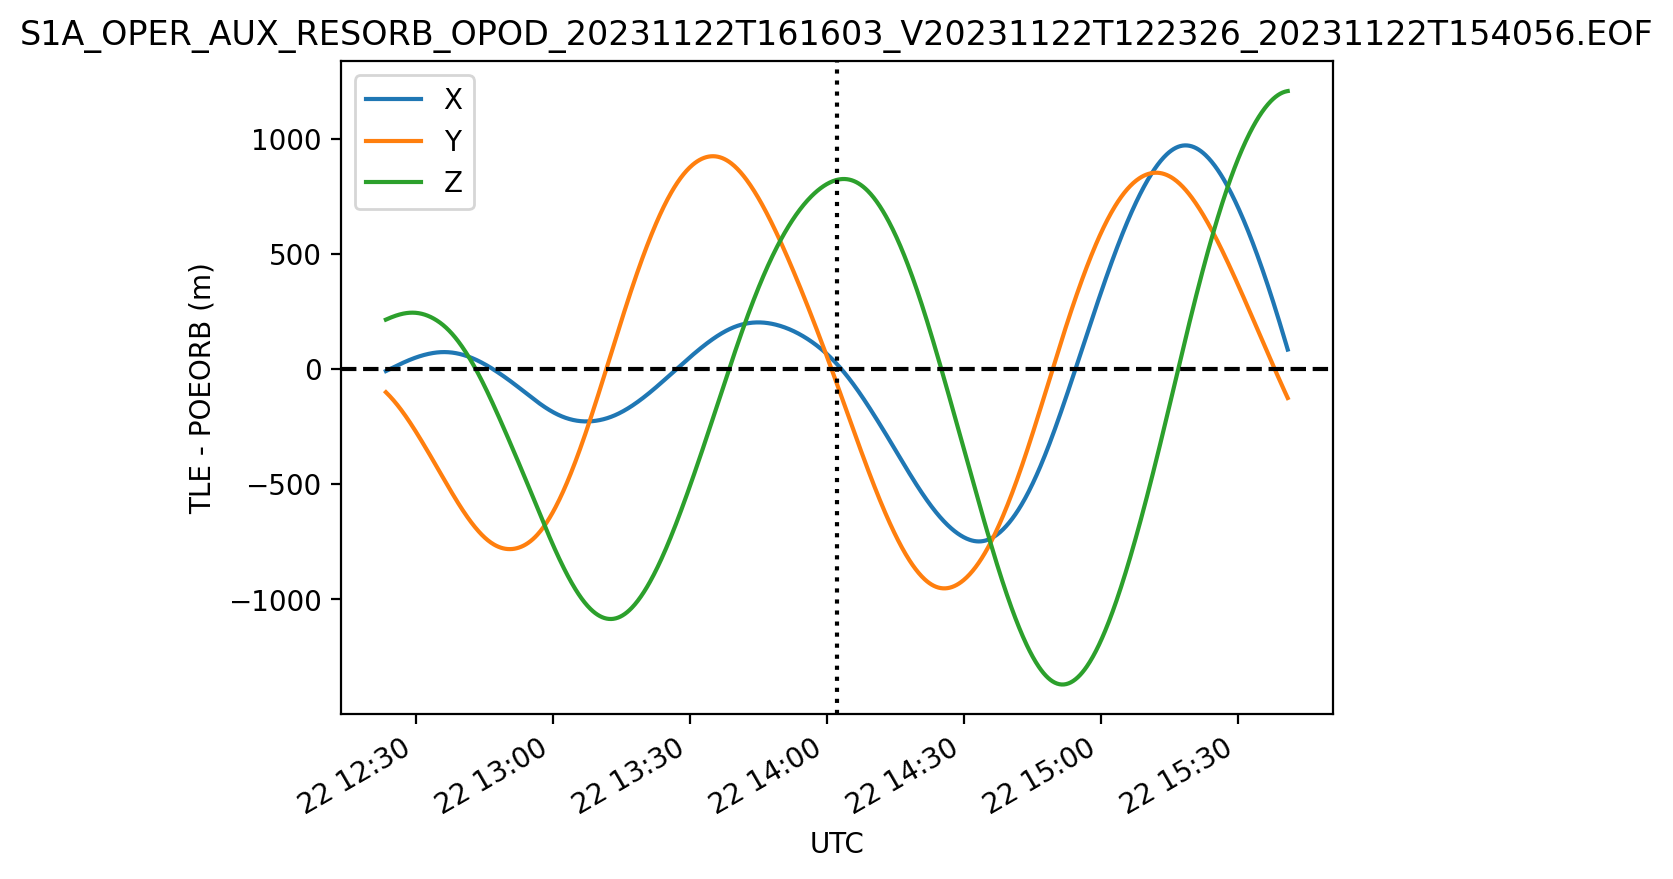

In [35]:
positions = ['X','Y','Z']
diff[positions].plot();
plt.axhline(0,color='k',linestyle='--')
plt.axvline(epoch, color='k',linestyle='dotted', label='TLE epoch')
plt.ylabel('TLE - POEORB (m)')
plt.title(paths[0]);
plt.savefig('tle-vs-resorb.png')

#### Interpretation:
- TLE solutions within +/-800m of RESORB solutions within 3 hours of TLE epoch
- 3 hours pre-eopch soulions +/- 200m
- resorb posted 8 hours ago (notebook run at '2023-11-20 17:29:57.768677'
- oldest resorb positions better? or back-propagation of TLE solution better than forward?

In [36]:
# How often are S1 TLEs posted? search previous 1month:
# Last 30 days
query = f'{API}/class/gp_history/NORAD_CAT_ID/{norad_id}/EPOCH/>now-30/orderby/CREATION_DATE%20DESC/format/json'

# All TLES in month
#query = f'{API}/class/gp_history/NORAD_CAT_ID/{norad_id}/EPOCH/2023-10-01--2023-12-31/orderby/CREATION_DATE%20DESC/format/json'


# All TLES
#query = f'{API}/class/gp_history/NORAD_CAT_ID/{norad_id}/orderby/TLE_LINE1%20ASC/format/json'

data = session.get(query).json()
dfo = pd.DataFrame(data)
len(dfo)

141

In [42]:
# NOTE: mean time between TLEs is 5 hours!
dfo['EPOCH'] = pd.to_datetime(dfo.EPOCH)
dfo = dfo.drop_duplicates('EPOCH')
dfo.EPOCH.diff(-1).describe()

count                          138
mean     0 days 05:09:49.408885565
std      0 days 03:09:27.819384004
min       -1 days +20:42:30.834432
25%         0 days 03:17:29.118696
50%         0 days 04:56:13.706016
75%         0 days 06:34:58.310832
max         1 days 00:41:08.428128
Name: EPOCH, dtype: object

In [43]:
dmin = dfo.EPOCH.min()
dmax = dfo.EPOCH.max()

In [44]:
import matplotlib.dates as mdates

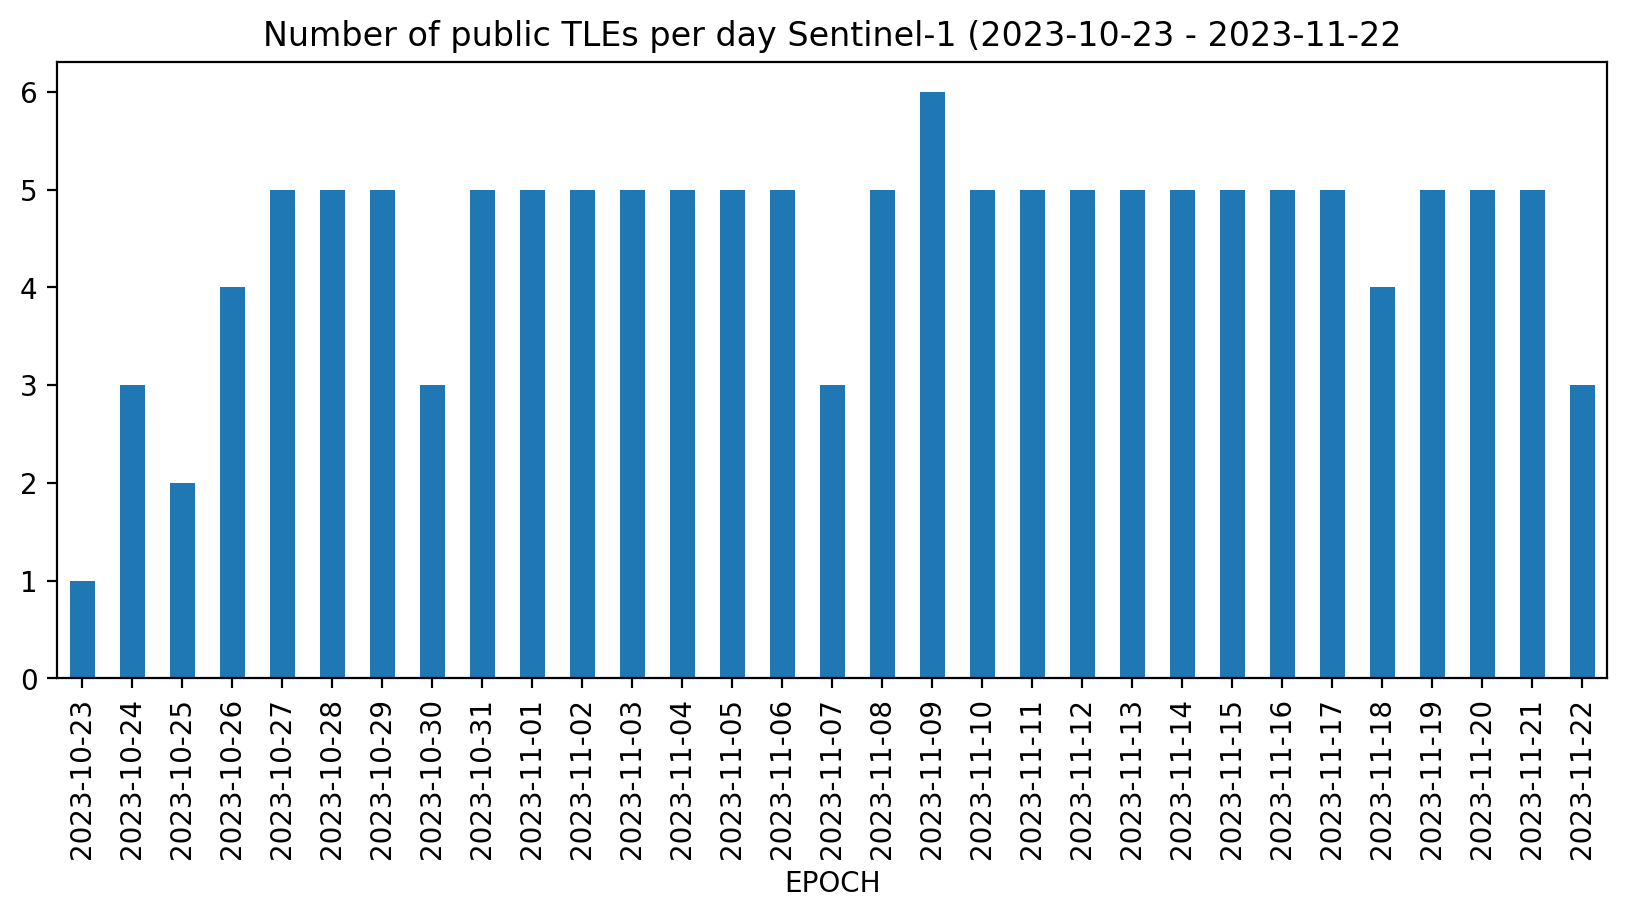

In [45]:
# Count TLE posting frequency
fig,ax = plt.subplots(figsize=(10,4))
dfo.groupby(dfo.EPOCH.dt.date)['GP_ID'].count().plot.bar(ax=ax);
plt.title(f'Number of public TLEs per day Sentinel-1 ({dmin.date()} - {dmax.date()}');
#fig.autofmt_xdate()
#ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator())) # hmm, does not work correctly!

In [46]:
# Try another date at least 20 days ago to compare against POEORB
# Specific date
query = f'{API}/class/gp_history/NORAD_CAT_ID/{norad_id}/EPOCH/2023-10-16--2023-10-17/orderby/CREATION_DATE%20DESC/format/json'


data = session.get(query).json()
dfo = pd.DataFrame(data)
len(dfo)
dfo['EPOCH'] = pd.to_datetime(dfo.EPOCH)
dfo[['CREATION_DATE','EPOCH']]

,CREATION_DATE,EPOCH
0,2023-10-17T06:26:18,2023-10-16 21:34:51.234240
1,2023-10-17T05:00:31,2023-10-16 21:34:51.234240
2,2023-10-16T22:16:17,2023-10-16 18:17:22.092864
3,2023-10-16T20:23:12,2023-10-16 13:21:08.376480
4,2023-10-16T14:16:17,2023-10-16 11:42:23.803200
5,2023-10-16T09:46:17,2023-10-16 06:46:10.079040
6,2023-10-16T06:16:33,2023-10-16 05:07:25.504896


In [47]:
dfo.EPOCH.diff(-1) # 1 to 4 hours between epochs

0          0 days 00:00:00
1   0 days 03:17:29.141376
2   0 days 04:56:13.716384
3   0 days 01:38:44.573280
4   0 days 04:56:13.724160
5   0 days 01:38:44.574144
6                      NaT
Name: EPOCH, dtype: timedelta64[ns]

In [48]:
# Time between CREATEION_DATE and EPOCH?
pd.to_datetime(dfo.CREATION_DATE) - dfo.EPOCH 

0   0 days 08:51:26.765760
1   0 days 07:25:39.765760
2   0 days 03:58:54.907136
3   0 days 07:02:03.623520
4   0 days 02:33:53.196800
5   0 days 03:00:06.920960
6   0 days 01:09:07.495104
dtype: timedelta64[ns]

In [49]:
#for duplicate EPOCH timestamps keep most recent CREATION_DATE?
# Let's compare with precise orbit data
# Get orbit for S1... hmm quite slow. #want 1 day after acquisitions date
paths = download_eofs(['2023-10-17'], ['S1A'])

In [50]:
paths

[PosixPath('S1A_OPER_AUX_POEORB_OPOD_20231105T080844_V20231015T225942_20231017T005942.EOF')]

In [51]:
df = read_orbit_file(paths[0])
df.head(3)

,UTC,Absolute_Orbit,X,Y,Z,VX,VY,VZ,Quality
UTC,,,,,,,,,
2023-10-15 22:59:42,2023-10-15 22:59:42,50782,-1.267035e+06,8.592440e+05,6.897890e+06,-1740.689090,7278.219604,-1223.867481,NOMINAL
2023-10-15 22:59:52,2023-10-15 22:59:52,50782,-1.284317e+06,9.319894e+05,6.885263e+06,-1715.804014,7270.717363,-1301.559842,NOMINAL
2023-10-15 23:00:02,2023-10-15 23:00:02,50782,-1.301350e+06,1.004656e+06,6.871860e+06,-1690.738340,7262.364914,-1379.106441,NOMINAL


In [52]:
print(f'{df.UTC.min()}, {df.UTC.max()}')

2023-10-15 22:59:42, 2023-10-17 00:59:42


In [53]:
tle = dfo.iloc[-1] # oldest

In [54]:
tle.EPOCH

Timestamp('2023-10-16 05:07:25.504896')

In [55]:
satellite = sky.EarthSatellite(tle.TLE_LINE1, tle.TLE_LINE2, 'Sentinel-1A')
satellite

<EarthSatellite Sentinel-1A catalog #39634 epoch 2023-10-16 05:07:26 UTC>

In [56]:
# Slow! could parallelize.
dfTLE = df.apply(propagate_positions, args=(satellite,), axis=1)
dfTLE.head()

,X,Y,Z,VX,VY,VZ
UTC,,,,,,
2023-10-15 22:59:42,-1.267000e+06,8.586854e+05,6.897943e+06,-1740.860095,7278.322048,-1223.224642
2023-10-15 22:59:52,-1.284285e+06,9.314318e+05,6.885323e+06,-1715.975200,7270.826628,-1300.918361
2023-10-15 23:00:02,-1.301319e+06,1.004099e+06,6.871926e+06,-1690.909649,7262.481011,-1378.466390
2023-10-15 23:00:12,-1.318102e+06,1.076679e+06,6.857754e+06,-1665.667473,7253.285844,-1455.860038
2023-10-15 23:00:22,-1.334632e+06,1.149162e+06,6.842809e+06,-1640.252719,7243.241869,-1533.090628


In [57]:
cols = ['X','Y','Z','VX','VY','VZ']

diff = (dfTLE - df[cols]).dropna()
diff.head()

,X,Y,Z,VX,VY,VZ
UTC,,,,,,
2023-10-15 22:59:42,34.487094,-558.624885,53.115532,-0.171005,0.102444,0.642839
2023-10-15 22:59:52,32.781008,-557.544806,59.539482,-0.171186,0.109265,0.641481
2023-10-15 23:00:02,31.073969,-556.395953,65.949484,-0.171309,0.116097,0.640051
2023-10-15 23:00:12,29.366535,-555.178204,72.344834,-0.171375,0.122939,0.638547
2023-10-15 23:00:22,27.659273,-553.891439,78.724763,-0.171383,0.129787,0.636969


In [66]:
diff[['X','Y','Z']].values

array([[  34.48709434, -558.62488502,   53.11553194],
       [  32.78100805, -557.54480552,   59.53948154],
       [  31.07396871, -556.39595283,   65.94948435],
       ...,
       [-377.98760134,  101.80850864,  -17.27117284],
       [-380.25671722,  102.2992931 ,  -17.30088663],
       [-382.48620459,  102.79111658,  -17.33069026]])

UTC
2023-10-15 22:59:42    562.203150
2023-10-15 22:59:52    561.672284
2023-10-15 23:00:02    561.151835
2023-10-15 23:00:12    560.641603
2023-10-15 23:00:22    560.141366
                          ...    
2023-10-17 00:59:02    387.091924
2023-10-17 00:59:12    389.483964
2023-10-17 00:59:22    391.839116
2023-10-17 00:59:32    394.156869
2023-10-17 00:59:42    396.436708
Length: 9361, dtype: float64

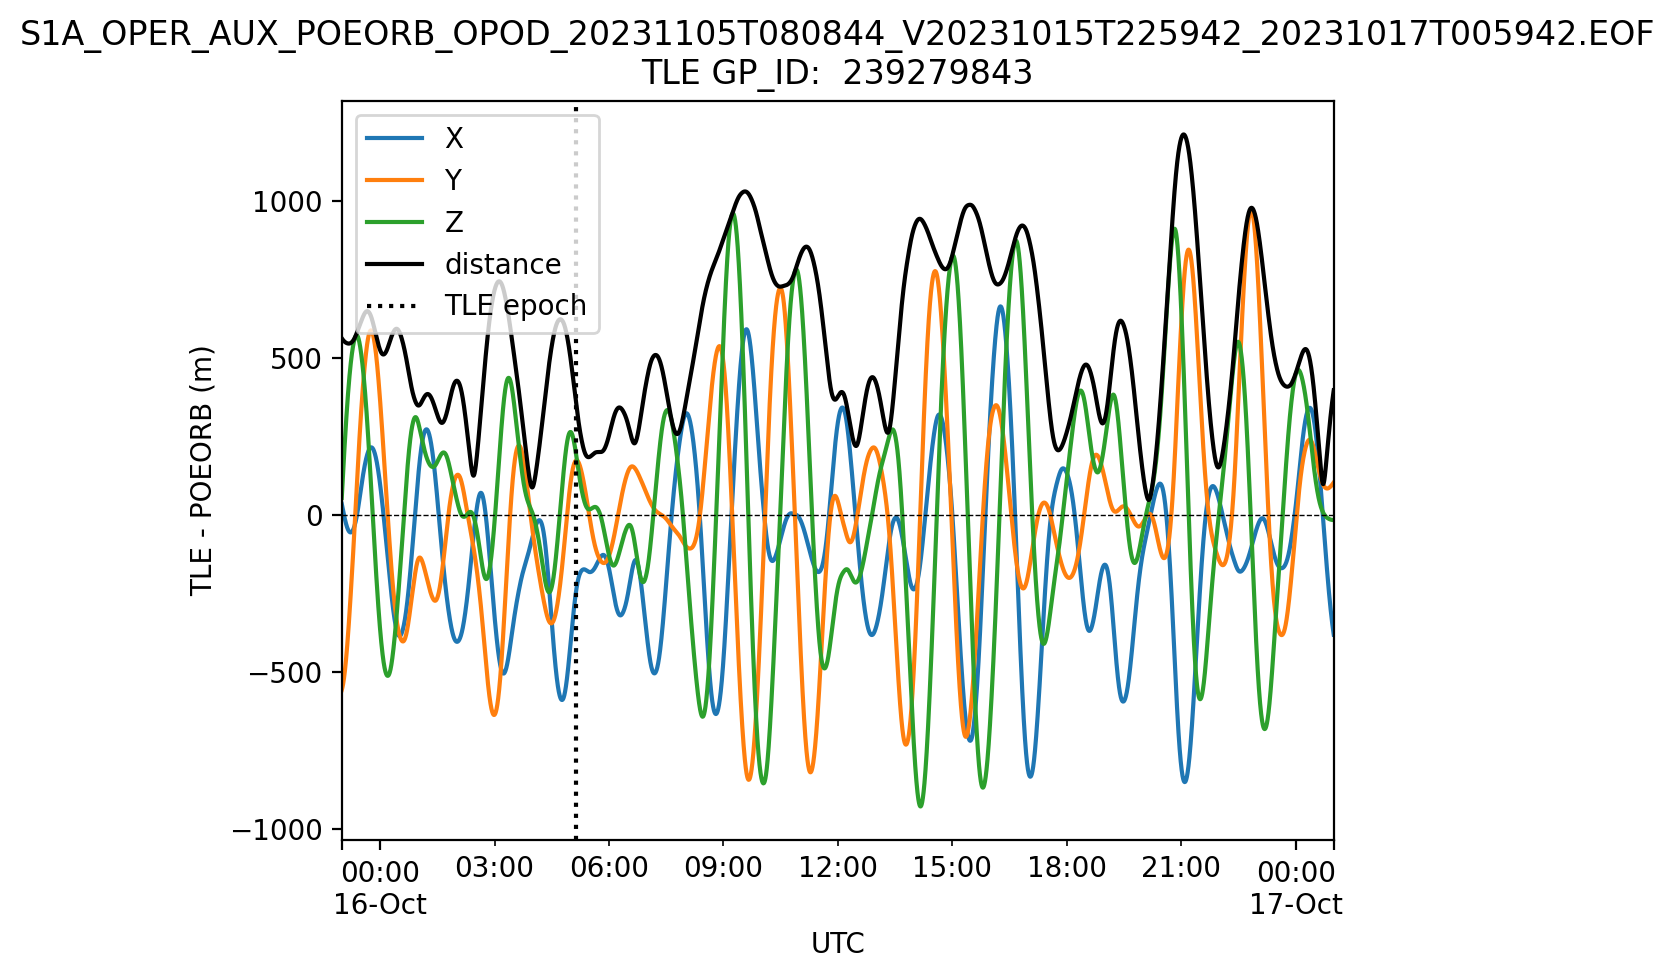

In [70]:
positions = ['X','Y','Z']
diff['distance'] = diff[positions].apply(np.linalg.norm, axis=1)
diff[positions].plot();
diff['distance'].plot(color='k');
plt.axhline(0,color='k',linewidth=0.5,linestyle='--')
plt.axvline(tle.EPOCH, color='k',linestyle='dotted', label='TLE epoch')
plt.ylabel('TLE - POEORB (m)')
plt.title(f'{paths[0]}\nTLE GP_ID:  {tle.GP_ID}')
plt.legend();
#plt.savefig('tle-vs-poeorb.png')